# ESRI Concurrent Licensing Use Evaluation Process

#### INSTRUCTIONS
Welcome,  
Click the "Cell" menu above and choose "Run All".  
The notebook will automatically slide your screen to the bottom cell and you will see an asterick \* in the sqare brackets of cells as they wait to be run. A number will appear in the square brackets once a cell has been run. When a number appears in the final cell of the notebook you know the process is complete and your output file is ready. There are "VALIDATION STEPS" in this notebook that serve to check outputs, inputs, and to identify issues with the process and/or data. If the square brackets are empty instead of containing an \* or a number, it means you haven't run them or there was an error during a run. Scroll through the process to find the error output and see your friendly local Python developer.  
To run a cell hit "shift + enter".  
Tips on operating the VALIDATION STEP functionality: A '#' symbol at the start of a line of code means it is commented out and will not be executed. To uncomment the code  simply delete the "#" symbol or hit "ctrl + /" while your cursor is on the line of code.   


# Imports

In [ ]:
from datetime import datetime
import numpy as np
import os
import pandas as pd

##### EXAMPLE FOR USER TO FOLLOW (screenshot)
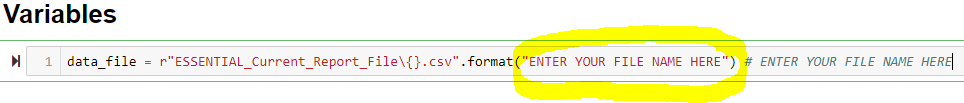

# Variables

In [ ]:
data_file = r"ESSENTIAL_Current_Report_File\{}.csv".format("Example Activity Report Generated by OpenLM SEPTtoFEB") # ENTER YOUR FILE NAME HERE
assert(os.path.exists(data_file))
data_file

In [ ]:
column_datatypes = {"Feature": str, "Product": str, "Start Time": str, "End Time": str, "Workstation": str,
                    "User Name": str, "First Name": str, "Last Name": str, "Email": str, 
                    "Total usage time (hours)": float}
dt_value = datetime.today().strftime("%Y%m%d")
fields_to_drop = ["Version", "License Type", "Borrowed", "Server", "Vendor", "Additional Key", "Host Ids", "IP",
                  "Project", "Group", "Usage Time w/in filter period", "Consumed Tokens", "Idle Time (hours)",
                  "Token Usage Time", "Token Usage Time w/in filter period", "Session ID",
                  "Source"]
output_excel_file_name = "ESSENTIAL_Process_Output_Files\{}_ESRI_Concurrent_Licensing_Reports.xlsx".format(dt_value)
product_label_substitutions_file = r"ESSENTIAL_Value_Substitution_Files\ProductCodeToProductLabel_SubstitutionsList.csv"
workstation_agency_substitutions_file = r"ESSENTIAL_Value_Substitution_Files\WorkstationToAgency_SubstitutionsList.csv"

# Process the Data
#### Create Master Dataframe from OpenLM Report (.csv) of Interest

In [ ]:
master_df = pd.read_csv(filepath_or_buffer=data_file, dtype=str)

#### Drop Unneeded Fields

In [ ]:
master_df.drop(columns=fields_to_drop, inplace=True)

#### Replace Commas in "Total usage time (hours)" Field and Adjust Column Data Types for Calculation Steps

In [ ]:
# clean_commas_from_usage_time. pandas.DataFrame.replace wasn't working to find comma in string ??
def replace_commas(value):
    value = str(value)
    if "," in value:
        value =value.replace(",", "")
    return float(value)

master_df["Total usage time (hours)"] = master_df["Total usage time (hours)"].apply(func=replace_commas)
master_df = master_df.astype(dtype=column_datatypes)

### Field Calculations

#### Get Product Label Values as a Python Dictionary

In [ ]:
product_label_substitutions_df = pd.read_csv(filepath_or_buffer=product_label_substitutions_file)
product_label_substitutions_df.set_index("VALUE", inplace=True)
product_label_substitutions_dict = product_label_substitutions_df.to_dict(orient="dict")["REPLACEMENT"]

#### Replace Product Code values with Product Label replacements and Apply

In [ ]:
unrecognized_values_set = set()
def product_code_to_label(value):
    try:
        value = product_label_substitutions_dict[value]
    except KeyError:
        value = value.strip("*") # In case ran this step before and already has an '*'
        unrecognized_values_set.add(value)
        value = "*" + value
    return value

master_df["Product"] = master_df["Product"].apply(func=product_code_to_label)

##### VALIDATION STEP: Unrecognized Product Names

In [ ]:
# If no unrecognized values then you will see 'set()' printed out
unrecognized_values_set

#### Get Workstation Substitution Values as a Python Dictionary

In [ ]:
workstation_substitutions_df = pd.read_csv(filepath_or_buffer=workstation_agency_substitutions_file)
workstation_substitutions_df.set_index("VALUE", inplace=True)
workstation_substitutions_dict = workstation_substitutions_df.to_dict(orient="dict")["REPLACEMENT"]

#### Add New Fields and Calculate

In [ ]:
# Calculate Product_Workstation field
master_df["Product_Workstation"] = master_df["Product"] + "_" + master_df["Workstation"]

# Calculate Product_Username field
master_df["Product_Username"] = master_df["Product"] + "_" + master_df["User Name"]

# Convert Start and End Time fields
master_df["Start Time"] = pd.to_datetime(arg=master_df["Start Time"], dayfirst=True)
master_df["End Time"] = pd.to_datetime(arg=master_df["End Time"], dayfirst=True)

# Calculate Date field from datetime object. For Peak Usage Report
master_df["Date"] = master_df["End Time"].apply(lambda x: x.strftime("%Y%m%d"))

In [ ]:
# Calculate Agency field
def workstation_to_agency(workstation_value):
    result = "Research"
    for key, value in workstation_substitutions_dict.items():
        if key in workstation_value:
            result = value
            break
        else:
            continue
    return result

In [ ]:
master_df["Agency"] = master_df["Workstation"].apply(func=workstation_to_agency)

##### VALIDATION STEP: Unique 'Agency' values and counts

In [ ]:
master_df["Agency"].value_counts()

##### VALIDATION STEP: See Records of Workstation Values where 'Agency' equals 'Research'

In [ ]:
# master_df[(master_df["Agency"] == "Research")][["Workstation", "Agency"]]

##### VALIDATION STEP: See Workstation Substitutions Values

In [ ]:
workstation_substitutions_dict

##### VALIDATION STEP: See the Unique Agency Codes Where Substitution Resulted in 'Research'

In [ ]:
master_df[(master_df["Agency"] == "Research")]["Workstation"].unique()

# Report Generation

Note to future developers. The .agg() function is applied to entire dataframe but only numeric fields are evaluated. 
The 'Total usage time (hours)' column is the only numeric column as of 20190215. If another numeric field is added to the input data then this would need to be revised.

### Product_Workstation Report

In [ ]:
agency_product_workstation_gbdf = master_df.groupby(by=["Agency", "Product_Workstation"], axis=0)
agency_product_workstation_usage_df = agency_product_workstation_gbdf.sum()
agency_product_workstation_count = agency_product_workstation_gbdf["Product_Workstation"].agg(np.count_nonzero)
agency_product_workstation_count.name = "Frequency"
product_workstation_report = agency_product_workstation_usage_df.join(other=agency_product_workstation_count, how="left")

### Product_Username Report

In [ ]:
agency_product_username_gbdf = master_df.groupby(by=["Agency", "Product_Username"], axis=0)
agency_product_username_usage_df = agency_product_username_gbdf.agg(np.sum)
agency_product_username_count = agency_product_username_gbdf["Product_Username"].agg(np.count_nonzero)
agency_product_username_count.name = "Frequency"
product_username_report = agency_product_username_usage_df.join(other=agency_product_username_count, how="left")

### Evaluation of Product Use by Agency 

In [ ]:
agency_product_gbdf = master_df.groupby(by=["Agency", "Product"], axis=0)
agency_product_usage_df = agency_product_gbdf.agg(np.sum)
agency_product_count_series = agency_product_gbdf["Product"].agg(np.count_nonzero)
agency_product_count_series.name = "Frequency"
agency_username_count_series = agency_product_gbdf["User Name"].nunique()
agency_username_count_series.name = "Unique Usernames"
agency_workstation_count_series = agency_product_gbdf["Workstation"].nunique()
agency_workstation_count_series.name = "Unique Workstations"
agency_product_count_report = agency_product_usage_df.join(other=agency_product_count_series, 
                                                           how="left").join(other=agency_workstation_count_series, 
                                                                            how="left").join(other=agency_username_count_series, 
                                                                            how="left")

### Peak Usage Report

In [ ]:
peak_usage_gbdf = master_df.groupby(by=["Agency", "Date", "Product"], axis=0)
usernames_per_day_series = peak_usage_gbdf["User Name"].nunique()
usernames_per_day_series.name = "Unique Usernames"
usernames_per_day_df = usernames_per_day_series.to_frame()
usernames_per_day_gbdf = usernames_per_day_df.groupby(by=["Agency", "Product"], axis=0)
peak_usage_report = usernames_per_day_gbdf.max().rename(columns={"Unique Usernames": "Max Licenses"})

##### VALIDATION STEP: Inspect for Specific Agency Product Usage
Use the below code to verify the findings above for each agencies max usage across all dates a product was used by that agency. After a successful run of the process, you can edit the agency abbreviation and product label values below, and run both cells in order and interrogate the data.

In [ ]:
 # EDIT MY VALUES
agency_abbreviation_you_want_to_check = "SHA"
product_label_you_want_to_check = "ArcGIS Desktop Advanced"

In [ ]:
try:
    agency_isolation_df = usernames_per_day_df.xs(key=agency_abbreviation_you_want_to_check, axis=0, level=0)
    product_isolation_series = agency_isolation_df.xs(key=product_label_you_want_to_check, axis=0, level=1).agg(np.max)
except KeyError as ke:
    print("Key Error occurred. {key} not found. Try again.".format(key=ke))
product_isolation_series.name = "{} - {}".format(agency_abbreviation_you_want_to_check, product_label_you_want_to_check)
product_isolation_series

### Write the Report Data to an Excel File

In [ ]:
with pd.ExcelWriter(path=output_excel_file_name, datetime_format="YYYY-MM-DD") as writer:
    product_workstation_report.to_excel(writer, sheet_name="Product Workstation")
    product_username_report.to_excel(writer, sheet_name="Product Username")
    agency_product_count_report.to_excel(writer, sheet_name="Agency Product Use Evaluation")
    peak_usage_report.to_excel(writer, sheet_name="Peak Usage")